Importing Necessary Libraries

In [0]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
import tensorflow as tf
from keras.callbacks import ModelCheckpoint
import os
import re
import datetime

Using TensorFlow backend.


**Reading CSV Files**

In [0]:
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')
submission = pd.read_csv('sample_submission.csv')

**Dropping Un necessary Columns**

In [0]:
train_data = train_data.drop(['id'],axis = 1)
train_data

,label,tweet
0,0,#fingerprint #Pregnancy Test https://goo.gl/h1...
1,0,Finally a transparant silicon case ^^ Thanks t...
2,0,We love this! Would you go? #talk #makememorie...
3,0,I'm wired I know I'm George I was made that wa...
4,1,What amazing service! Apple won't even talk to...
...,...,...
7915,0,Live out loud #lol #liveoutloud #selfie #smile...
7916,0,We would like to wish you an amazing day! Make...
7917,0,Helping my lovely 90 year old neighbor with he...
7918,0,Finally got my #smart #pocket #wifi stay conne...


***Checking whether dataset is balanced or not ????***

In [0]:
print(train_data[train_data['label'] == 1].size)
print(train_data[train_data['label'] == 0].size)

4052
11788


Text(0, 0.5, 'Frequency')

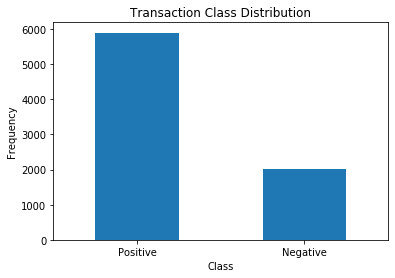

In [0]:
LABELS = ['Positive','Negative']
count_classes = pd.value_counts(train_data['label'], sort = True)

count_classes.plot(kind = 'bar', rot=0)

plt.title("Transaction Class Distribution")

plt.xticks(range(2), LABELS)

plt.xlabel("Class")

plt.ylabel("Frequency")


***Pre-Processing the Text***
***Removal of # Tags and other punctuation in train and test data ***

In [0]:
train_data['tweet'] = train_data['tweet'].apply((lambda x:re.sub("\#", " ",x.lower())))
train_data['tweet'] = train_data['tweet'].apply((lambda y:re.sub("http://\S+|https://\S+"," ", y)))

test_data['tweet'] = test_data['tweet'].apply((lambda x:re.sub("\#", " ",x.lower())))
test_data['tweet'] = test_data['tweet'].apply((lambda y:re.sub("http://\S+|https://\S+"," ", y)))


train_data['tweet'] = train_data['tweet'].apply((lambda x: re.sub('[^a-zA-z0-9\s]','',x)))
test_data['tweet'] = test_data['tweet'].apply((lambda x: re.sub('[^a-zA-z0-9\s]','',x)))

In [0]:
#Create independent and Dependent Features
columns = train_data.columns.tolist()
# Filter the columns to remove data we do not want 
columns = [c for c in columns if c not in ["label"]]
# Store the variable we are predicting 
target = "label"
# Define a random state 
state = np.random.RandomState(42)
X = train_data[columns]
Y = train_data[target]
# Print the shapes of X & Y
print(X.shape)
print(Y.shape)

(7920, 1)
(7920,)


**As the dataset is imbalanced to Balance that we can use RandomOverSampler Technique to Balance the dataset**

In [0]:
# from imblearn.over_sampling import RandomOverSampler    
# os =  RandomOverSampler(ratio=0.5)
# X_train_res, y_train_res = os.fit_sample(X, Y)
# X_train_res.shape,y_train_res.shape
# X_train_res
# type(X_train_res)

***Padding the text to a Fixed Length***

In [0]:
max_fatures = 2000
tokenizer = Tokenizer(num_words=max_fatures, split=' ')
tokenizer.fit_on_texts(train_data['tweet'].values)
X = tokenizer.texts_to_sequences(train_data['tweet'].values)
X = pad_sequences(X)
X[:2]


array([[   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0, 1324,   31,   95,   64,   41,  145,
         120,  135,  130,    1],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,   85,    8,   55,  114,    6,    3,
         256,   17,  304,  287]], dtype=int32)

In [0]:
X.shape

(7920, 48)

**Preparing Train and validation**

In [0]:
Y = pd.get_dummies(train_data['label']).values
print(Y)
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.10, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

[[1 0]
 [1 0]
 [1 0]
 ...
 [1 0]
 [1 0]
 [1 0]]
(7128, 48) (7128, 2)
(792, 48) (792, 2)


# Building Model

In [0]:
embed_dim = 128
lstm_out = 196

model = Sequential()
model.add(Embedding(max_fatures, embed_dim,input_length = X.shape[1]))
model.add(SpatialDropout1D(0.4))
model.add(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(2,activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model.summary())





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 48, 128)           256000    
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 48, 128)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 196)               254800    
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 394       
Total params: 511,194
Trainable params: 511,194
Non-trainable params: 0
_________________________________________________________________
None


In [0]:
X

array([[   0,    0,    0, ...,  135,  130,    1],
       [   0,    0,    0, ...,   17,  304,  287],
       [   0,    0,    0, ...,  143,  337, 1227],
       ...,
       [   0,    0,    0, ...,  166,   39,    4],
       [   0,    0,    0, ...,    7,  343,  465],
       [   0,    0,    0, ...,  103, 1896,   52]], dtype=int32)

In [0]:
batch_size = 128
model.fit(X_train, Y_train, epochs = 15, batch_size=batch_size, verbose = 1,validation_data=(X_test,Y_test))

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 7128 samples, validate on 792 samples
Epoch 1/15





7128/7128 [==============================] - 28s 4ms/step - loss: 0.4323 - acc: 0.7977 - val_loss: 0.2562 - val_acc: 0.8876
Epoch 2/15
7128/7128 [==============================] - 27s 4ms/step - loss: 0.2450 - acc: 0.8925 - val_loss: 0.2247 - val_acc: 0.8990
Epoch 3/15
7128/7128 [==============================] - 27s 4ms/step - loss: 0.2056 - acc: 0.9133 - val_loss: 0.2223 - val_acc: 0.9028
Epoch 4/15
7128/7128 [==============================] - 27s 4ms/step - loss: 0.1846 - acc: 0.9249 - val_loss: 0.2317 - val_acc: 0.8965
Epoch 5/15
7128/7128 [==============================] - 27s 4ms/step - loss: 0.1729 - acc: 0.9318 - val_loss: 0.2524 - val_acc: 0.8876
Epoch 6/15
7128/7128 [==============================] - 27s 4ms/step - loss: 0.1562 - acc: 0.9362 - val_loss: 0.2523 - val_acc: 0.8851
Epoch 7/15
7128/7128 [===================

In [0]:
model.save('vidhya_nlp.hdf5')

In [0]:
max_fatures = 2000
tokenizer = Tokenizer(num_words=max_fatures, split=' ')
tokenizer.fit_on_texts(test_data['tweet'].values)
test = tokenizer.texts_to_sequences(test_data['tweet'].values)
test = pad_sequences(test,maxlen=48)

In [0]:
test.shape

(1953, 48)

In [0]:
Y_pred = model.predict_classes(test)

In [0]:
submission = submission.drop(['id'],axis = 1)
submission['id'] = test_data['id']
# print(submission)
print(len(submission))
print(len(Y_pred))

1953
1953


In [0]:
submission['label'] = Y_pred
submission.to_csv('final_submission.csv',index=True)